In [271]:
#%pip install --upgrade pip
# %pip install -q --upgrade jupyter
# %pip install -q pyts
# %pip install -q nbformat>=4.2.0
# %pip show -q ipython
# %pip show -q nbformat
# %pip install -q --upgrade plotly

# %pip install -q yfinance

In [272]:
from __future__ import print_function

import os
import sys
import glob
import time

import torch
print(torch.__version__)
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler, Subset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from math import floor

from sklearn.model_selection import KFold
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from pyts.image import GramianAngularField

import yfinance as yf

#set gpu env
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device",device)
print("cuda version",torch.version.cuda)

2.3.0+cu121
Device cuda:0
cuda version 12.1


In [273]:
scenario = 0

def Delete_Scenario_Files():
    scenario_files = glob.glob('*scenario*') #find files
    iteration_files = glob.glob('*iteration*')
    optimizer_files = glob.glob('*optimizer*')
    model_files = glob.glob('*model*')

    files_to_delete = scenario_files + iteration_files + optimizer_files + model_files
    files_to_delete = [file for file in files_to_delete if file != 'model_card.md']
    
    for file in files_to_delete:
        try:
            os.remove(file)
            print(f"Deleted {file}")
        except OSError as e:
            print(f"Error deleting {file}: {e}")

def Save_BayesOpt_Model(scenario, net):
    PATH = f'./model_bayesOpt_iteration_{scenario}.pth'
    torch.save(net.state_dict(), PATH)

def Save_Scenario_State_Model(scenario, net):
    PATH = f'./model_scen_{scenario}_state.pth'
    torch.save(net.state_dict(), PATH)

def Save_Scenario_Full_Model(scenario, net):
    PATH = f'./model_scen_{scenario}_full.pth'
    torch.save(net, PATH)

def Load_State_Model(net, PATH):
    print("Loading State Model")
    net.load_state_dict(torch.load(PATH))
    net.eval()
    return net

def Load_Full_Model(PATH):
    if os.path.exists(PATH):
        print("Loading Full Model")
        return torch.load(PATH)
    else:
        print(f"Model {PATH} does not exist")

def Clear_Scenario_Log(scenario):
    with open(f'scenario_{scenario}.txt', 'w') as file:
        file.write('')

def Scenario_Log(output_string):
    with open(f'scenarios_output.txt', 'a') as file:
        file.write('\n\n' + output_string)

def Load_BayesOpt_Model(scenario, net):
    PATH = f'./bayesian_optimization_saved_models/model_bayesOpt_iteration_{scenario}.pth'
    print("path model is ",PATH)
    net.load_state_dict(torch.load(PATH))
    net.eval()
    return net

#Delete_Scenario_Files()

## Import Financial Data

In [274]:
#close price time period
start_date = '2021-10-01'
#end_date = '2023-12-01'
end_date = '2022-02-15'

In [275]:
ticker = 'SIVBQ'
dataset = yf.download(ticker, start=start_date, end=end_date, interval='1d')

print("num rows",dataset.shape[0])
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)
dataset = dataset.dropna().dropna()
dataset.dropna(how='any', inplace=True)
print("Num rows for df Close col",len(dataset['Close']))
print(dataset.columns)
dataset = dataset.reset_index()
#reorder to split the data to train and test
desired_order = ['Date','Open', 'Close', 'High', 'Low']
if 'Date' in dataset.columns:
    dataset = dataset[desired_order]
else:
    print("Column 'Date' is missing.")
dataset = dataset.set_index('Date')
print(dataset.head())
#print(dataset.iloc[521],dataset.iloc[522],dataset.iloc[523])
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')
# pd.reset_option('display.max_colwidth')

[*********************100%%**********************]  1 of 1 completed

num rows 94
Num rows for df Close col 94
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
                  Open       Close        High         Low
Date                                                      
2021-10-01  650.000000  664.530029  669.570007  648.065002
2021-10-04  663.989990  649.349976  669.000000  645.729797
2021-10-05  657.909973  665.380005  669.174988  652.072571
2021-10-06  654.039978  659.849976  663.919983  643.219971
2021-10-07  670.929993  665.559998  679.000000  663.280029


Graph to compare rebased prices with the S&P Financials index

[*********************100%%**********************]  1 of 1 completed


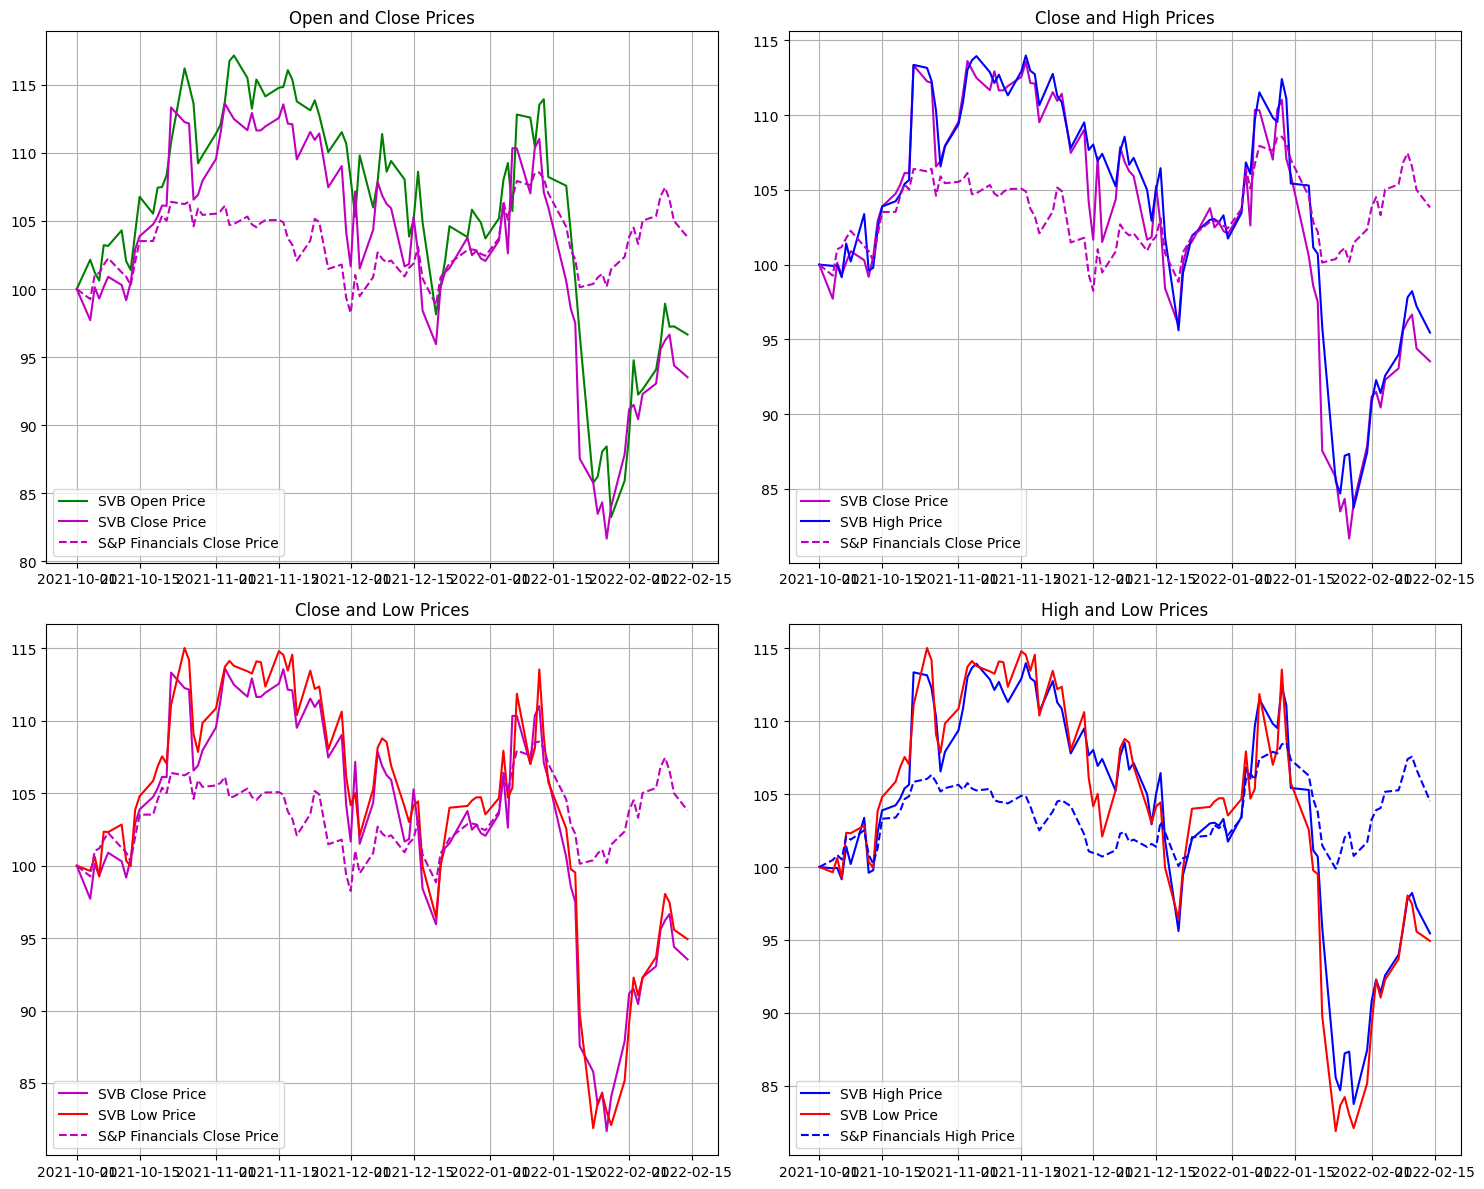

In [276]:
sp_financials_ticker = '^SP500-40'
sp_financials_data = yf.download(sp_financials_ticker, start=start_date, end=end_date, interval='1d')

svb_data = dataset.dropna()
sp_financials_data = sp_financials_data.dropna()

svb_data = svb_data[svb_data.index <= end_date]
sp_financials_data = sp_financials_data[sp_financials_data.index <= end_date]

#rebase
svb_rebased = svb_data / svb_data.iloc[0] * 100
sp_financials_rebased = sp_financials_data / sp_financials_data.iloc[0] * 100

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

axs[0, 0].plot(svb_rebased.index, svb_rebased['Open'], label='SVB Open Price', color='g')
axs[0, 0].plot(svb_rebased.index, svb_rebased['Close'], label='SVB Close Price', color='m')
axs[0, 0].plot(sp_financials_rebased.index, sp_financials_rebased['Close'], label='S&P Financials Close Price', color='m', linestyle='--')
axs[0, 0].set_title('Open and Close Prices')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(svb_rebased.index, svb_rebased['Close'], label='SVB Close Price', color='m')
axs[0, 1].plot(svb_rebased.index, svb_rebased['High'], label='SVB High Price', color='b')
axs[0, 1].plot(sp_financials_rebased.index, sp_financials_rebased['Close'], label='S&P Financials Close Price', color='m', linestyle='--')
axs[0, 1].set_title('Close and High Prices')
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(svb_rebased.index, svb_rebased['Close'], label='SVB Close Price', color='m')
axs[1, 0].plot(svb_rebased.index, svb_rebased['Low'], label='SVB Low Price', color='r')
axs[1, 0].plot(sp_financials_rebased.index, sp_financials_rebased['Close'], label='S&P Financials Close Price', color='m', linestyle='--')
axs[1, 0].set_title('Close and Low Prices')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(svb_rebased.index, svb_rebased['High'], label='SVB High Price', color='b')
axs[1, 1].plot(svb_rebased.index, svb_rebased['Low'], label='SVB Low Price', color='r')
axs[1, 1].plot(sp_financials_rebased.index, sp_financials_rebased['High'], label='S&P Financials High Price', color='b', linestyle='--')
axs[1, 1].set_title('High and Low Prices')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

## Imaging Algorithm: Generate Gramian angular field (GAF) images from time series data 
Uses popular time series imaging algorithm in [pyts' GramianAngularField method](https://pyts.readthedocs.io/en/stable/auto_examples/image/plot_single_gaf.html)

GAF represents time series in a polar coordinate system instead of the typical Cartesian coordinates by considering the trigonometric sum or difference between stock prices and calculate the correlation within different time intervals. [Source.](https://towardsdatascience.com/rgb-gaf-image-a-possible-solution-to-one-weak-point-of-gramian-angular-field-imaging-ffc6b31edfbe)

[Making Gram matrix CNN ready](https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3)

Gramian Matrix of a set of n vectors:

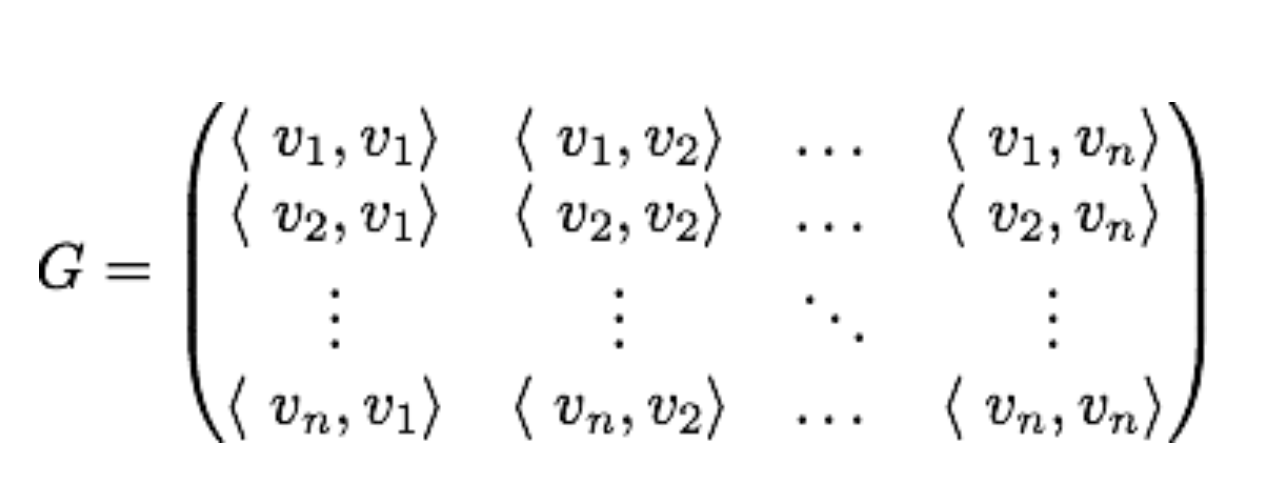

Gramian Matrix of units vector where Φ(i, j) is the angle between vectors i and j

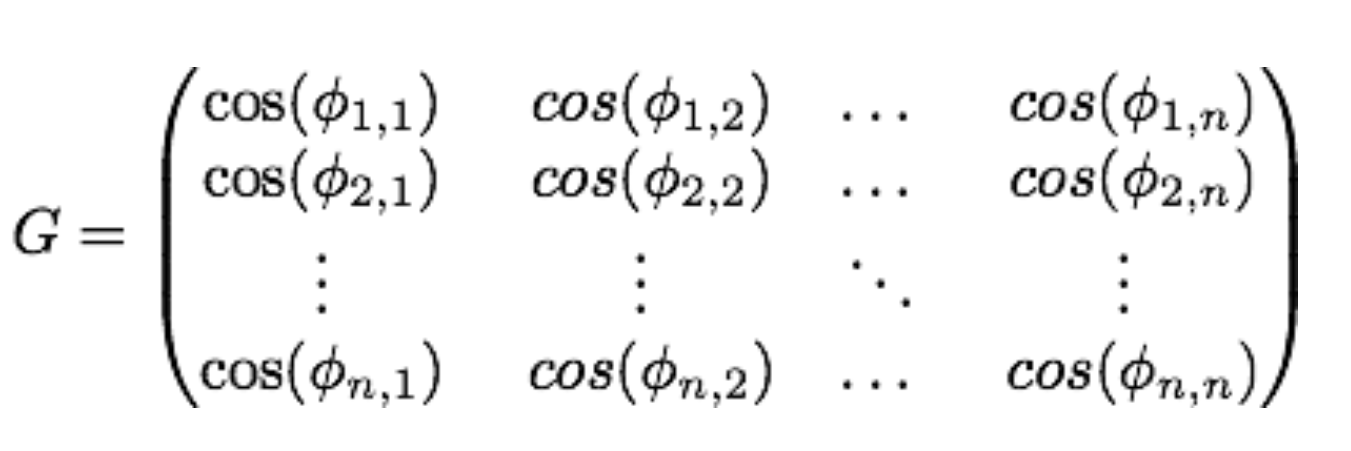

Therefore the dot product operation in GAF provides us with the correlation between each set of observations whilst preserving the temporal relationship. To account for the bias introduced from the inner product between two distinct observations or an observation with itself, a further summation or difference matrix (GASF or GADF) transformation is applied. In this notebook we apply summation.

Since GAF provides the combination of the datapoints requested, each image of size 32 in this notebook, the dot product combination of 32 data points yields 1024 points in an image (32x32 image). Since we request GAF images of size 32x32, we can calculate the number of images GAF will generate for one feature (e.g. closing price time series), in the example images below 524 data points / 32 = 16 images; thus 524 data points yield 16,384 gaf values represented over 16 images size 32x32.

In [277]:
def generate_gaf_images(dataset, gaf_img_sz=32, method="summation", sample_range=(0,1)):
    #print("len data series received:",len(dataset),"size",dataset.size)

    #determine num of gaf_img_szX images with gaf_img_sz datapoints
    num_images_to_generate = floor(len(dataset) / gaf_img_sz)
    #print("len dataset",len(dataset),"num_images_to_generate",num_images_to_generate)
    
    #reshape dataset into number of images
    dataset = dataset[:num_images_to_generate*gaf_img_sz].reshape(num_images_to_generate, gaf_img_sz)
    #print("data in GAF",dataset)
    
    #TODO: Explore label set according to each feature
    #print("num_images_to_generate","dataset 1",dataset[1])
    mean_price_list=[]
    for i in range(num_images_to_generate):
        mean_price_list.append(np.mean(dataset[i]))
        #print("Num images to generate",num_images_to_generate,"Dataset mean",np.mean(dataset[i]),"dataset",dataset)
    #print("prices in GAF",price_list)
    #print("image_size",gaf_img_sz)
    
    gaf = GramianAngularField(image_size=gaf_img_sz, method=method, sample_range=sample_range)
    gaf_images= gaf.fit_transform(dataset)
    #print("gaf_image",gaf_images.shape)
    #print("returning price list",mean_price_list)
    
    return gaf_images, mean_price_list

## Visualize Closing Price for one image in GAF
A darker patch indicates lower correlation between the different elements of the price time series, possibly due to higher volatility or noise. The opposite is true for the lighter patches.

94
len datapoints in dataset 94
 (2, 32, 32)
gaf_images.shape (2, 32, 32) data points in images 2048 gaf image [0] shape (32, 32) data points in image [0] 1024


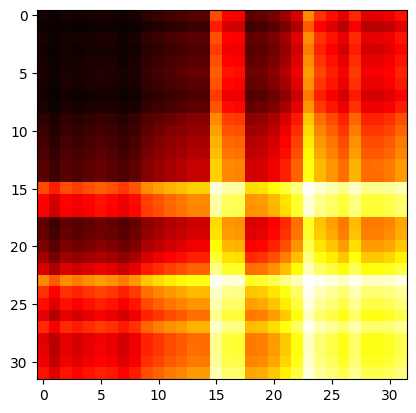

In [278]:
gaf_method='summation'

full_feature_data = np.array(dataset['Close'])
print(len(dataset['Close']))
#print("feature_dataset_array",feature_data)
print("len datapoints in dataset",len(full_feature_data))

np.set_printoptions(threshold=np.inf)
gaf_images, mean_price_list= generate_gaf_images(full_feature_data, gaf_img_sz=32, method=gaf_method)

print("",gaf_images.shape)
plt.imshow(gaf_images[0],cmap='hot')
print("gaf_images.shape",gaf_images.shape,"data points in images",gaf_images.size, "gaf image [0] shape",gaf_images[0].shape, "data points in image [0]",gaf_images[0].size)
#print("gasf image[0] data",gaf_images[0])
#print("Gasf data",gasf_images)

np.set_printoptions()

## Generate images for open, high, low, close

We transpose the resulting image list to represent:
+ 15: number of images
+ 4: number of image channels/features. Each image has 5 ="Open", "High", "Low", "Close"
+ 32: image height
+ 32: image width
+ the label is the 32+1 price for each time series chunk (image) corresponding to the relevant feature

In [279]:
np.set_printoptions(threshold=np.inf)

#TODO: Instead of insert a list in each list for each feature, insert the elements directly
def generate_multiple_feature_images(dataset, cols_used, image_size=32, method="summation", sample_range = (0, 1)):
    
    feature_image_dataset_list=[[] for _ in range(len(cols_used))]
    feature_price_dataset_list=[[] for _ in range(len(cols_used))] #="Open", "High", "Low", "Close" , "Adj Close"
    feature_label_dataset_list=[] #next value for each chunk of ="Open", "High", "Low", "Close" , "Adj Close"
    column_idx = 0

    total_single_feature_chunks = 0

    for idx, column_name in enumerate(dataset.columns):

      #create open,  close, high, low images. The order of 
      if column_name in ["Open", "Close", "High", "Low"]:
        temp_image_list = []
        temp_price_list = []
        temp_label_list = []
        #print("dataset idx", idx, "len rows this data feature", len(dataset[i]), "dataset[i].shape", dataset[i].shape, "dataset i:", dataset[i])
        print(f"Processing",column_name)

        full_feature_data = dataset[column_name].values
        full_feature_num_samples = len(full_feature_data)
        #print("full_feature_num_samples",full_feature_num_samples)
        #if column_name == "Open": print("total input data",full_feature_data)

        num_windows = image_size
        #add 1 for last window label
        adj_feature_num_samples = full_feature_num_samples - (image_size + 1)
        #print("window size",adj_feature_num_samples)

        #loop by data_chunk so each chunk represents the price series that we slide by image_size
        # TODO: parallelism
        for curr_window_index in range(num_windows):
          
          curr_sliding_window_data = full_feature_data[curr_window_index:adj_feature_num_samples+curr_window_index]
          #print(f"Curr window len {len(curr_sliding_window_data)} first value {curr_sliding_window_data[0]} next value {curr_sliding_window_data[1]} last value {curr_sliding_window_data[490]}")
          #if curr_window_index ==0 or curr_window_index ==1: print(f"Curr window len {len(curr_sliding_window_data)} input: {curr_sliding_window_data[:300]}")

          target_num_chunks = floor(adj_feature_num_samples / image_size)
          #print(f"Target number of chunks for curr Window {column_name}",target_num_chunks)
          
          for cur_chunk in range(target_num_chunks):
            
            if column_name == "Open": total_single_feature_chunks += 1
            
            #chunk size of image size
            data_chunk = curr_sliding_window_data[cur_chunk*image_size:(cur_chunk*image_size)+image_size]
            #if (cur_chunk < 5 and curr_window_index==0):
              #print("cur_chunk",cur_chunk,"input chunk",data_chunk)
            #append gaf image to image list. store price feature values in price list
            gaf_images, price_list = generate_gaf_images(data_chunk, gaf_img_sz=image_size, method=method, sample_range=sample_range)
            temp_image_list.append(gaf_images)
            #***print("At chunk",cur_chunk,"input chunk size",len(data_chunk),"shape gaf images",gaf_images.shape, "len temp image list",len(temp_image_list))
            
            temp_price_list.append(curr_sliding_window_data[(cur_chunk*image_size)+image_size])
            # if (cur_chunk < 5 and curr_window_index==0):
            #   print("curr chunk",data_chunk)
            #   print("cur chunk label",curr_sliding_window_data[(cur_chunk*image_size)+image_size])
            # if(cur_chunk==0):
            #   print("Price Data Pre-Gaf: i", cur_chunk, "len",len(data_chunk), "shape", feature_data.shape, "data",data_chunk)
            #   print("Image Returned: idx", idx, "image size", gaf_images.size, f"first {image_size} image vals", gaf_images.flatten()[:image_size])
            
            #print("At chunk",cur_chunk,"input chunk size",len(data_chunk),"len price_list",len(price_list),price_list)
            
            #get next single value after the chunk as label to list
            #print("appending to temp label list",feature_data[cur_chunk + image_size + 1])
            temp_label_list.append(full_feature_data[cur_chunk + image_size + 1])
            #feature_label_index_dataset_list.append(feature_data[cur_chunk + image_size + 1])
            #print("chunk",cur_chunk,"label for",column_name,"price",feature_data[cur_chunk + image_size + 1])
            #if(column_name == "Open"):
              #index position for the label of this chunk
              #feature_label_index_dataset_list.append(cur_chunk + image_size + 1)
              #print("at chunk",cur_chunk,"feature label list",feature_label_index_dataset_list)
        
        if column_name == "Open": print("total chunks Open feature:",total_single_feature_chunks)
        #print(f"Column {column_name} temp image list len to append",len(temp_image_list))
        feature_image_dataset_list[column_idx].append(temp_image_list)
        #print("feature_image_dataset_list",feature_image_dataset_list)
        feature_price_dataset_list[column_idx].append(temp_price_list)
        #print("price list",price_list)
        feature_label_dataset_list.append(temp_label_list)
        column_idx += 1

    # print("Final len images",len(feature_image_dataset_list),
    #        "len image list index (i.e. feature) 0",len(feature_image_dataset_list[0][0]))
    # print("Final len price list",len(feature_price_dataset_list),
    #        "len feature_price_dataset_list index 0 (i.e. column 0)", len(feature_price_dataset_list[0][0]),feature_price_dataset_list)
    # print("Final len labels", len(feature_label_dataset_list),feature_label_dataset_list) # 2455=total range*5
    
    feature_image_dataset_list = np.array(feature_image_dataset_list) 
    #print("Final Shape of images before transpose:", feature_image_dataset_list.shape)
    
    #transpose image for CNN
    #(5, 1, 491, 1, 32, 32)
    feature_image_dataset_list= np.transpose(feature_image_dataset_list, (1, 3, 0, 2, 4, 5))
    #print("Final Shape of images after transpose:", feature_image_dataset_list.shape)

    return feature_image_dataset_list, feature_price_dataset_list, feature_label_dataset_list

#Generate images from dataset
gaf_method="summation"
sample_range = (0, 1)
image_size = 32 #(x,y)
cols_used = ["Open", "High", "Low", "Close"]
cols_used_count = sum(column_name in cols_used for column_name in dataset.columns)
feature_image_dataset_list, feature_price_dataset_list, feature_label_dataset_list = generate_multiple_feature_images(dataset, cols_used, image_size=image_size, method=gaf_method, sample_range=sample_range)

print("shape [0] set",np.array(feature_image_dataset_list[0]).shape)

np.set_printoptions()

Processing Open
total chunks Open feature: 32
Processing Close
Processing High
Processing Low
shape [0] set (1, 4, 32, 32, 32)


In [280]:
def generate_gaf_images(dataset, gaf_img_sz=32, method="summation", sample_range=(0,1)):
    #print("len data series received:",len(dataset),"size",dataset.size)

    #determine num of gaf_img_szX images with gaf_img_sz datapoints
    num_images_to_generate = floor(len(dataset) / gaf_img_sz)
    #print("len dataset",len(dataset),"num_images_to_generate",num_images_to_generate)
    
    #reshape dataset into number of images
    dataset = dataset[:num_images_to_generate*gaf_img_sz].reshape(num_images_to_generate, gaf_img_sz)
    #print("data in GAF",dataset)
    
    #TODO: Explore label set according to each feature
    #print("num_images_to_generate","dataset 1",dataset[1])
    mean_price_list=[]
    for i in range(num_images_to_generate):
        mean_price_list.append(np.mean(dataset[i]))
        #print("Num images to generate",num_images_to_generate,"Dataset mean",np.mean(dataset[i]),"dataset",dataset)
    #print("prices in GAF",price_list)
    #print("image_size",gaf_img_sz)
    
    gaf = GramianAngularField(image_size=gaf_img_sz, method=method, sample_range=sample_range)
    gaf_images= gaf.fit_transform(dataset)
    #print("gaf_image",gaf_images.shape)
    #print("returning price list",mean_price_list)
    
    return gaf_images, mean_price_list

## Visual representation of feature images for the same time range

Bottom image averages depth values of feature images (channels)

shape images array (1, 1, 4, 32, 32, 32) shape image (32, 32)


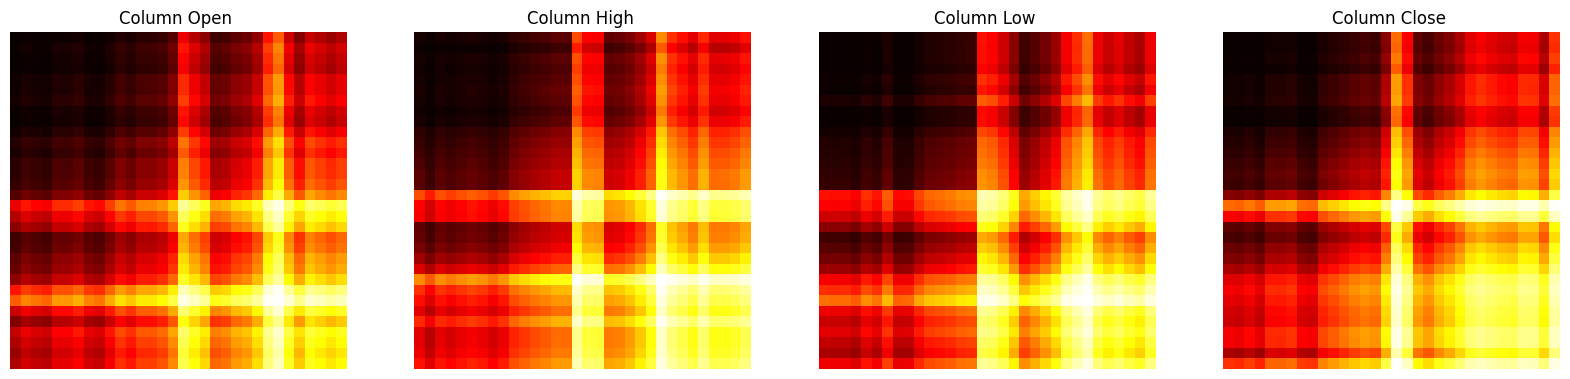

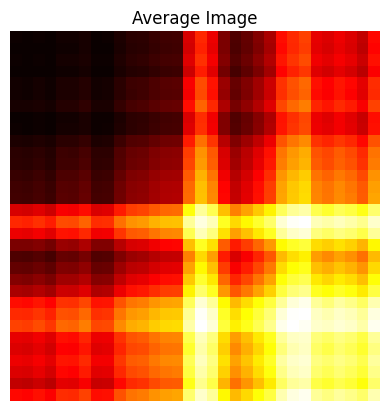

In [281]:
images_array=np.array(feature_image_dataset_list)
prices_array=np.array(feature_price_dataset_list) #not used
labels_array=np.array(feature_label_dataset_list)
#print("len price array",len(prices_array),prices_array.shape,prices_array)
#print("images_array",len(images_array[0][0][0]),"labels_array",len(labels_array[0]),"prices array",len(prices_array[0][0]))
#print("len img",len(images_array),"image shape",images_array.shape)#,"prices_array[0][0]",prices_array[0][0])
#print("len label",len(labels_array),"labels shape",labels_array.shape)#,"prices_array[0][0]",prices_array[0][0])

# Plot the first image of each column
fig, axes = plt.subplots(nrows=1, ncols=cols_used_count, figsize=(20, 6))
for ax in axes:
    ax.set_aspect('equal')

#EXPLANATION SHAPE
#shape images array (1, 1, 4, 480(=15 chunks * 32 windows), 32, 32)
#I get 15 images (32x32) for 491 data points (491 = 524 - 33 data points for sliding windows, i.e. 32+1 for label)
#I create 32*15=480 32x32images
#print("image",images_array[0])
print("shape images array",images_array.shape,"shape image",images_array[0][0][0][0].shape)
for i in range(cols_used_count):
    axes[i].imshow(images_array[0][0][i][0], cmap='hot')
    axes[i].set_title(f"Column {cols_used[i]} ")

#average first image of all features
average_images = []
for i in range(cols_used_count):
    average_images.append(images_array[0][0][i][0])

average_image = np.mean(average_images, axis=0)

# Hide axes
for ax in axes:
    ax.axis('off')

# Plot the average image separately
plt.figure()  # Create a new figure for the average image
plt.imshow(average_image, cmap='hot')
plt.title("Average Image")
plt.axis('off')  # Hide axes
plt.show()

In [282]:
#squeeze arrays
images_array = images_array.squeeze(axis=(0, 1))
print("len img",len(images_array),"image shape",images_array.shape)#,"prices_array[0][0]",prices_array[0][0])
print("len label",len(labels_array),"labels shape",labels_array.shape)#,"prices_array[0][0]",prices_array[0][0])


len img 4 image shape (4, 32, 32, 32)
len label 4 labels shape (4, 32)


## Prepare Training/Testing Datasets for Neural Network

Apply Transform to image to convert to tensor and normalize

In [283]:
def SetTransform(normalize_ftor=0.5,resolution_x=32,resolution_y=32):
    return transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([normalize_ftor], [normalize_ftor])
    #transforms.Resize((resolution_x, resolution_y))
    ])

Init Hyper-parameters

In [284]:
#Default hyperparameters

filter_size_1=(2, 3)
filter_size_2=(2, 2)
filter_size_3=(2, 3)

stride=2

output_conv_1=40#180#40
output_conv_2=12#180
output_FC_1=100#40
output_FC_2=70
final_FCLayer_output=1

learning_rate= 0.00001#0.0001#0.000001#0.000001#0.001#0.000001=0.56;0.00001=0.15
momentum = 0.9

dropout_probab=0

batch_size =1

num_epochs_input = 10000

transform = SetTransform(normalize_ftor=0.5, resolution_x=32, resolution_y=32)

In [285]:
def Generate_feature_image_dataset_list_f32(labels_array):
    feature_image_dataset_list_f32 = np.array(images_array).astype(np.float32)
    feature_image_dataset_list_f32 = feature_image_dataset_list_f32.reshape(-1, image_size, image_size)
    #images_array = np.transpose(feature_image_dataset_list, (1, 0, 2, 3))

    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    labels_array = np.array(labels_array)
    #print("labels array",labels_array)
    reshaped_labels_array = labels_array.reshape(-1, 1)
    #print("reshaped labels array",reshaped_labels_array)
    labels_scaled_list_f32 = scaler.fit_transform(reshaped_labels_array).reshape(-1,).astype(np.float32)
    #print("scaled labels",labels_scaled_list_f32)
    print("4D image array shape",images_array.shape)
    print("3D reshaped image array ",feature_image_dataset_list_f32.shape)
    print("labels shape",reshaped_labels_array.shape)
    
    return feature_image_dataset_list_f32, labels_scaled_list_f32

feature_image_dataset_list_f32, labels_scaled_list_f32 = Generate_feature_image_dataset_list_f32(labels_array)

4D image array shape (4, 32, 32, 32)
3D reshaped image array  (128, 32, 32)
labels shape (128, 1)


Prepare features data (close, high, low, etc) for Dataloader

In [286]:
class DataPrep(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs #all features in one large array
        self.labels = labels
        self.transform = SetTransform()

    def __len__(self):
      return len(self.inputs)

    def __getitem__(self, index):
        X = self.inputs[index]
        Y = self.labels[index]
        return X, Y
  
    def prepare_ordered_dataset(self):
        x = []
        y = []
        #print("len inputs", len(self.inputs), "shape", self.inputs.shape, self.inputs.shape[0])
        #print("len images 0",len(self.inputs), "len images 0:",len(self.inputs[0]))
        #print("images 0:",self.inputs[0])
        #print("labels",self.labels)
        #print("len labels", len(self.labels), self.labels.shape, self.labels.shape[0])
        for image_num in range(self.inputs.shape[0]):
            #print("len image data 0",len(self.inputs[data_window][0]),"shape",self.inputs[data_window].shape)
            #print("label data",self.labels[image_num][0])
            #print("imag num:",image_num)
            #print("image data at index image_num len:",len(self.inputs[image_num]))
            
            self.inputs[image_num] = self.transform(self.inputs[image_num])
            
            x.append(np.expand_dims(self.inputs[image_num], axis=0))
            y.append(self.labels[image_num])
            #print("img num",image_num,"label",self.labels[image_num])
            #print("img num",image_num,"img",self.inputs[image_num])
            #print("img num",image_num,"img len",len(self.inputs[image_num]))
            
        #cnn requests labels size (4,1) instead of (4)
        y = np.expand_dims(y, axis=1) 
        #print("size self",self.inputs.shape,self.labels.shape)
        #print("size self",len(x),len(y))
        dataset = [(img, label) for img, label in zip(x, y)]
        #print("type dataset returned",type(dataset), len(dataset), len(dataset[0]), len(dataset[1]))
        #print("len dataset[0][0]",len(dataset[0][0][0][0]))
        #print("len dataset[1][1]",len(dataset[1][1]))
        #print("dataset[0]",dataset[1])
        return dataset
        
        #return np.array(x),np.array(y)
    
    def split_data(self,dataset, batch_size=batch_size, test_size=0.2, train_shuffle=False):
        num_samples = len(dataset)
        #print("numsamples",num_samples)
        #num_test_samples = int(test_size * num_samples)
        #num_train_samples = num_samples - num_test_samples
        num_test_samples = int(num_samples//2) #divide by two as that's 2 features data for training and 2 for testing
        num_train_samples = num_samples - num_test_samples
        #print("num_train_samples",num_train_samples)
        #indices = np.random.permutation(num_samples)
        indices = np.arange(num_samples)
        train_indices = indices[:num_train_samples]
        test_indices = indices[num_train_samples:]
        print("len train",len(train_indices),"len test",len(test_indices))

        # train_sampler = SubsetRandomSampler(train_indices)
        # test_sampler = SubsetRandomSampler(test_indices)
        train_subset = Subset(dataset, train_indices)
        test_subset = Subset(dataset, test_indices)

        # Use SequentialSampler for both train and test subsets
        train_sampler = SequentialSampler(train_subset)
        test_sampler = SequentialSampler(test_subset)


        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler,shuffle=train_shuffle)
        test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

        #for e in train_loader:
            #print("train loader ele",e)

        # sample_batch = next(iter(train_loader))
        # input_shape = sample_batch[0].shape
        # label_shape = sample_batch[1].shape
        # print("input len",len(input_shape),"input shape",input_shape,"label len",len(label_shape))

        return train_loader, test_loader

In [287]:
def Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, train_shuffle=False, batch_size=batch_size):

    #print("feature_image_dataset_list_f32[0][0].shape",feature_image_dataset_list_f32[0][0].shape, "feature_image_dataset_list_f32[0][0].shape[0]", feature_image_dataset_list_f32[0][0].shape[0])

    #reshape for cnn
    #reshaped_feature_image_dataset_list_f32 = np.expand_dims(feature_image_dataset_list_f32[0][0].reshape(-1, *feature_image_dataset_list_f32[0][0].shape[2:]), axis=1)
    #print("feature_image_dataset_list_f32 shape",feature_image_dataset_list_f32.shape)
    #print("res",reshaped_feature_image_dataset_list_f32.shape)

    #generate a list for images and labels
    data_prep_class = DataPrep(feature_image_dataset_list_f32, labels_scaled_list_f32)

    #print("feature_image_dataset_list_f32",feature_image_dataset_list_f32[0][0].shape)
    #print("labels_scaled_list_f32",labels_scaled_list_f32.shape)
    #returns list size all observations of all features of size 2:
    #(image32x32,label) i.e. shape (4*480,32,32) and (4*480,1)
    dataset = data_prep_class.prepare_ordered_dataset()

    # for c in range(len(dataset[0])):
    #     print(f"size labels {c}",dataset[1][c].size)
    #     print(f"size image {c}",dataset[0][c].shape)

    batch_size = batch_size
    train_loader, test_loader = data_prep_class.split_data(dataset, 
                                                         batch_size=batch_size,
                                                         train_shuffle=train_shuffle)

    # for c,e in enumerate(train_loader):
    #     print("count",c)
        # print("type",type(e))
        # print("imga",e[0].shape)
        # print("label",e[1].shape)
    #returns 191 train_loaders that contain batch of 10 images32x32 and 10 labels
    #=191*10=1910 i.e. 80% of 2400 total
    return train_loader, test_loader
    

train_loader,test_loader = Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, batch_size=batch_size)

len train 64 len test 64


## CNN Design

dynamically calulate the shape of layers outputs

In [288]:
def conv_output_shape_dynamic(h_w, kernel_size=(1,1), stride=1):
        h = floor( (h_w[0] - kernel_size[0])/ stride) + 1
        w = floor( (h_w[1] - kernel_size[1])/ stride) + 1
        return h, w

In [289]:
class Net(nn.Module):
    def __init__(self,name="LeNet5Blend",
                 filter_size_1=filter_size_1, filter_size_2=filter_size_2, filter_size_3=filter_size_3, stride=stride,
                 output_conv_1=output_conv_1,output_conv_2=output_conv_2, output_FC_1=output_FC_1,output_FC_2=output_FC_2,
                 image_resolution_x=32,image_resolution_y=32,final_FCLayer_outputs=final_FCLayer_output,
                 dropout_probab=dropout_probab):
        super(Net, self).__init__()
        
        if name:
            self.name = name
        self.totalparams = 0
        self.output_conv_2=output_conv_2
        self.conv_output_size=0
        print();print("Convos & dropoutP:",output_conv_1,output_conv_2, dropout_probab)
        
        #num channels input, num channels output, filter size 
        self.conv1 = nn.Conv2d(1, output_conv_1, filter_size_1,stride=1)
        #filtersize,stride.
        #maxpool acts the same way in each channel, so doesn't need to be fed the num channels of the input
        self.pool = nn.MaxPool2d(kernel_size=filter_size_2, stride=stride)
        self.conv2 = nn.Conv2d(output_conv_1, output_conv_2, filter_size_3,stride=1)

        H_out_1, W_out_1 = conv_output_shape_dynamic((image_resolution_y, image_resolution_x), kernel_size=filter_size_1,stride=1)
        H_out_2, W_out_2 = conv_output_shape_dynamic((H_out_1, W_out_1), kernel_size=filter_size_2,stride=stride)
        H_out_3, W_out_3 = conv_output_shape_dynamic((H_out_2, W_out_2), kernel_size=filter_size_3,stride=1)
        H_out_4, W_out_4 = conv_output_shape_dynamic((H_out_3, W_out_3), kernel_size=filter_size_2,stride=stride)
        
        print("imgres",image_resolution_x,image_resolution_y)
        print("H_out_1, W_out_1",H_out_1, W_out_1)
        print("H_out_2, W_out_2",H_out_2, W_out_2)
        print("H_out_3, W_out_4",H_out_3, W_out_3)
        print("H_out_4, W_out_4",H_out_4, W_out_4)
        print("outputconv2",output_conv_2)
        self.conv_output_size = H_out_4 * W_out_4

        #Fully connected layers and apply dropout
        self.fc1 = nn.Linear(output_conv_2*self.conv_output_size, output_FC_1)
        if(dropout_probab>0): self.dropout1 = nn.Dropout(dropout_probab)
        self.fc2 = nn.Linear(output_FC_1, output_FC_2)
        if(dropout_probab>0): self.dropout1 = nn.Dropout(dropout_probab)
        self.fc3 = nn.Linear(output_FC_2, final_FCLayer_outputs)
        
        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)
        self.totalparams=total_params

    def forward(self, x):
        #print("Input shape:", x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print("After conv1 and pooling shape:", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("After conv2 and pooling shape:", x.shape)
        #-1 takes the batch size
        x = x.view(-1,self.output_conv_2*self.conv_output_size)
        #print("After flattening shape:", x.shape)
        x = F.relu(self.fc1(x))
        #print("After fc1 shape:", x.shape)
        x = F.relu(self.fc2(x))
        #print("After fc2 shape:", x.shape)
        x = self.fc3(x)
        #print("Output shape:", x.shape)
        return x

## Train and Test CNN

Init Weights

In [290]:
def weights_init_he(m):
    if isinstance(m, nn.Conv2d):
        #mode=fan_out: Used for convolutional layers to account for the output size of the layer
        nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        #mode=fan_in: Used for linear layers to account for the input size
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

Plot Gradients and Weights

In [291]:
def plot_data(weights_dict, gradients_dict, epoch):
    for name, weight_list in weights_dict.items():
        plt.figure(figsize=(10, 6))
        plt.title(f"Epoch {epoch + 1} - Weights {name}")
        
        for i, w in enumerate(weight_list):
            plt.plot(w.flatten())
        
        plt.xlabel('Weight Index')
        plt.ylabel('Weight Value')
        plt.legend(loc="upper right")
        plt.show()

    for name, gradient_list in gradients_dict.items():
        plt.figure(figsize=(10, 6))
        plt.title(f"Epoch {epoch + 1} - Gradients {name}")
        
        for i, g in enumerate(gradient_list):
            plt.plot(g.flatten())
        
        plt.xlabel('Gradient Index')
        plt.ylabel('Gradient Value')
        plt.legend(loc="upper right")
        plt.show()

Instantiate Net

In [292]:
net = Net(name='LeNet-5 Based Net', filter_size_1=filter_size_1, filter_size_2=filter_size_2,
            filter_size_3=filter_size_3, stride=stride,
            image_resolution_x=32,image_resolution_y=32,
            output_conv_1=output_conv_1, output_conv_2=output_conv_2,
            output_FC_1=output_FC_1, output_FC_2=output_FC_2,
            final_FCLayer_outputs=final_FCLayer_output,
            dropout_probab=dropout_probab)

def print_layer_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad and 'weight' in name:
            print(f"{name}: {param.numel()} weights")

net.to(device)
net.parameters()
print_layer_weights(net)


Convos & dropoutP: 40 12 0
imgres 32 32
H_out_1, W_out_1 31 30
H_out_2, W_out_2 15 15
H_out_3, W_out_4 14 13
H_out_4, W_out_4 7 6
outputconv2 12
LeNet-5 Based Net: total params: 60813
conv1.weight: 240 weights
conv2.weight: 2880 weights
fc1.weight: 50400 weights
fc2.weight: 7000 weights
fc3.weight: 70 weights


Train CNN

In [293]:
#torch.set_printoptions(threshold=torch.inf)

#print running_loss every [x] mini-batches
mini_batch_running_loss_check = 10#38
epoch_running_loss_check = 10
epoch_running_gradients_check = 40

def Train(learning_rate=learning_rate,momentum=momentum,
          train_loader=train_loader, net=net):
    
    start_time = time.time()

    print(f"Train params: learning_rate: {learning_rate}, momentum:{momentum}")

    net.apply(weights_init_he)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    #criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(num_epochs_input):

        gradients_dict = {name: [] for name, _ in net.named_parameters() if 'weight' in name}

        weights_dict = {name: [] for name, _ in net.named_parameters() if 'weight' in name}

        running_loss = 0.0

        first_batch = True
        
        for i, data in enumerate(train_loader, 0):
            #print(f"Batch {i + 1}")
            #get the inputs; data is a list of [inputs, labels]
            # print("image type",type(data[0]), "shape", data[0].shape)
            # print("image size",data[0].numel())
            # print("label type",type(data[1]), "shape", data[1].shape)
            # print("label size",data[1].numel())
            #print("**zero:",data[0])
            #print("type",type(data[1]),"**one:", data[1])
            #print("label pre",data[1])
            #data[1]=data[1].type(torch.LongTensor)
            inputs, labels = data[0].to(device), data[1].to(device)
            if i==0 and epoch==0:
                print("epoch",epoch,"data i",i,"len image",len(inputs), "shape",inputs.shape)
                print("epoch",epoch,"data i",i,"label",labels,"labels shape",labels.shape)
            
            # for e in data[1]:
            #     print("label",e.item())
            #print("label",data[1].item())
            #labels = labels.long()

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            #print("outputs shape",outputs.shape,outputs)
            #print("outputs",outputs)
            loss = criterion(outputs, labels)
            if loss is not None:
                loss.backward()
                optimizer.step()

                # Print optimizer's state_dict
                # print("Optimizer's state_dict:")
                # for var_name in optimizer.state_dict():
                #     print(var_name, "\t", optimizer.state_dict()[var_name])

                # print epoch/loss
                running_loss += loss.item()
                #if i % mini_batch_running_loss_check == (mini_batch_running_loss_check-1):    # print every x mini-batches
                #changed to show less results because with 10k epochs it cloggs github repo
                #if (epoch+ 1) % epoch_running_loss_check == 0 and  i % mini_batch_running_loss_check == (mini_batch_running_loss_check-1):
                if first_batch and ((epoch + 1) % epoch_running_gradients_check == 0):
                    print('[%d, %5d] Cum loss: %.6f' %
                        (epoch + 1, i + 1, running_loss / mini_batch_running_loss_check)) 
                    running_loss = 0.0

                if loss.item() < 0.000000001:
                    print(f"Loss is less than 0.000001:{loss.item()} Stopping training.")
                    return loss
                
                if first_batch and ((epoch + 1) % epoch_running_gradients_check == 0):
                    for name, param in net.named_parameters():
                        if 'weight' in name:
                            if param.grad is not None:
                                gradients_dict[name].append(param.grad.detach().cpu().numpy())
                            weights_dict[name].append(param.detach().cpu().numpy())

                    plot_data(weights_dict, gradients_dict, epoch)
                    first_batch = False
                    #print("epoch",epoch,"data i",i,"image",inputs)
                    #print("epoch",epoch,"data i",i,"label",labels)
                    #print("epoch",epoch,"outputs i",i,"outputs",outputs)
    
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.6f} seconds")
                
    return loss

#torch.set_printoptions()

Train params: learning_rate: 1e-05, momentum:0.9
epoch 0 data i 0 len image 1 shape torch.Size([1, 1, 32, 32])
epoch 0 data i 0 label tensor([[0.7898]], device='cuda:0') labels shape torch.Size([1, 1])
[40,     1] Cum loss: 0.001738


C:\Users\Sergio\AppData\Local\Temp\ipykernel_30992\2241954606.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


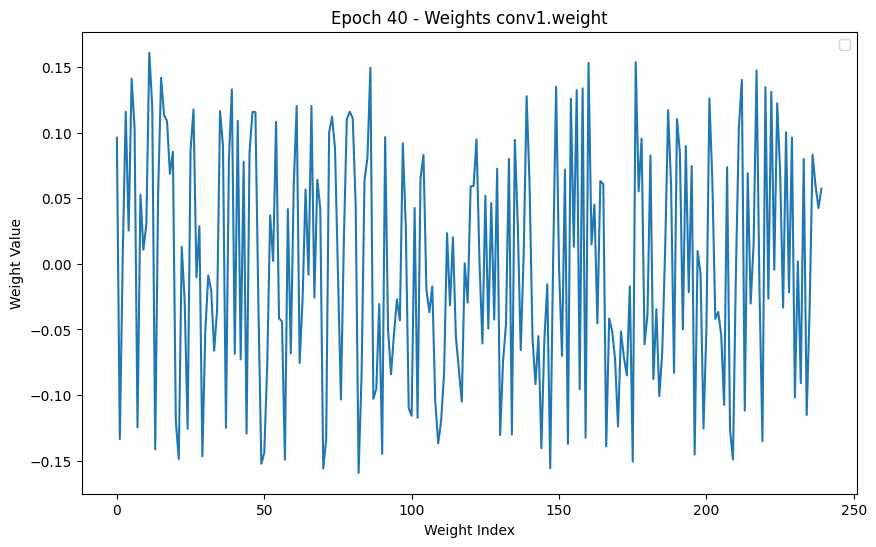

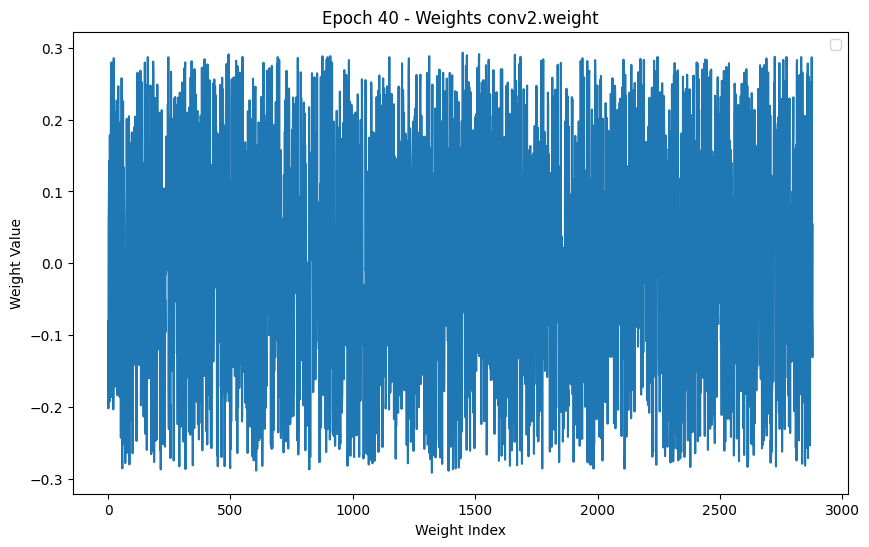

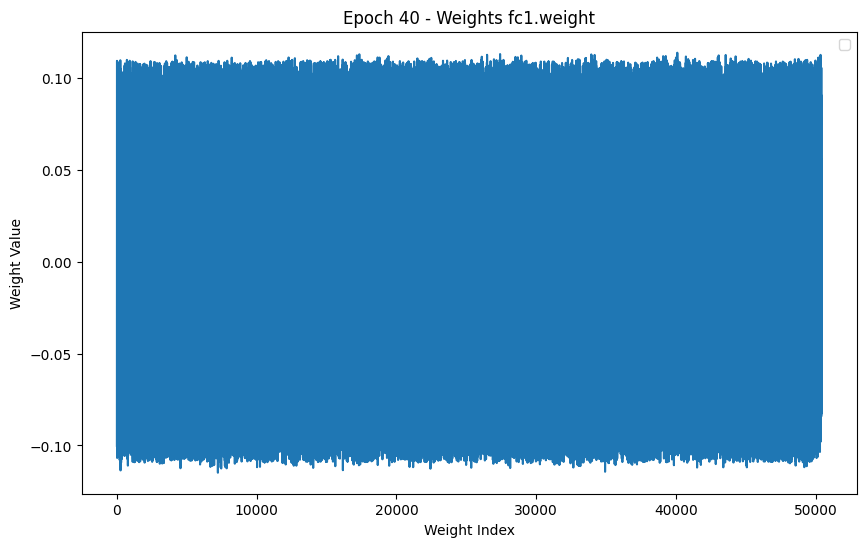

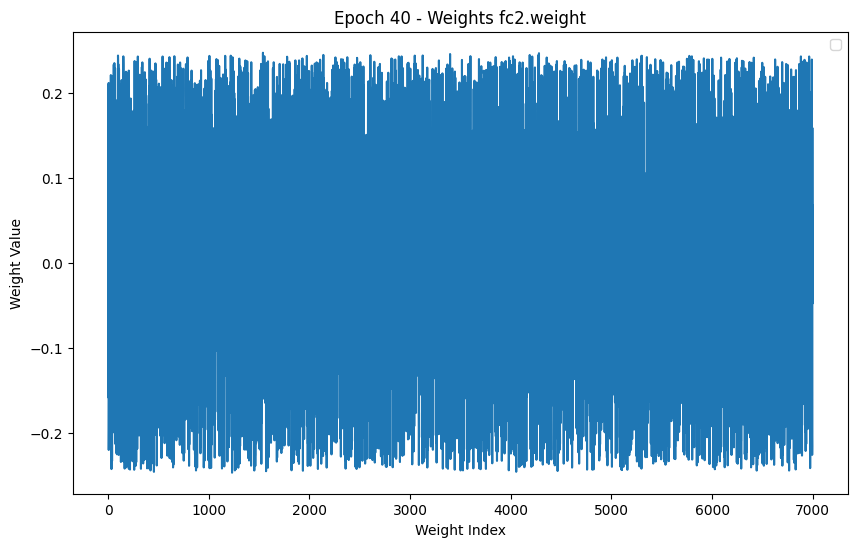

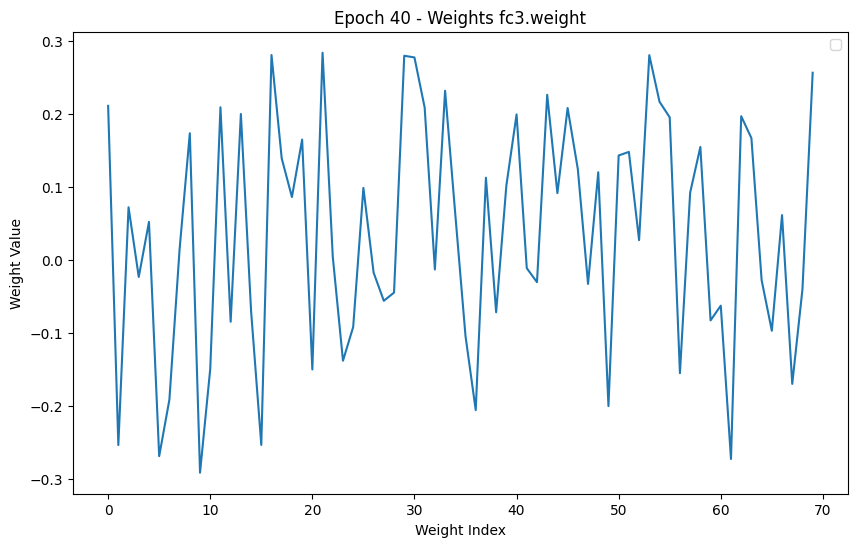

C:\Users\Sergio\AppData\Local\Temp\ipykernel_30992\2241954606.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


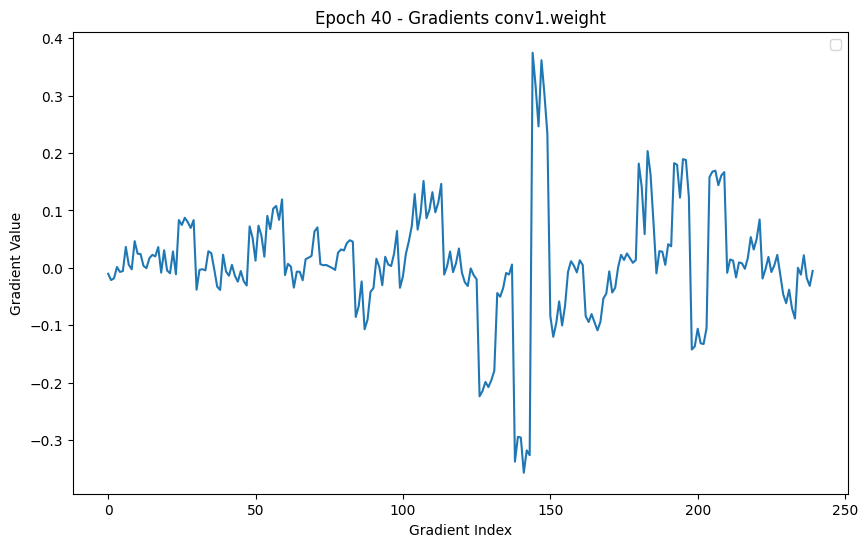

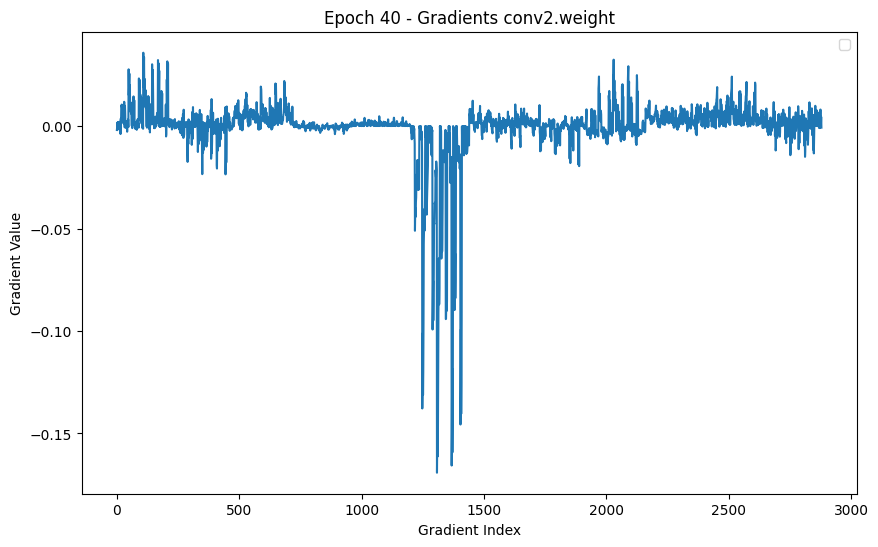

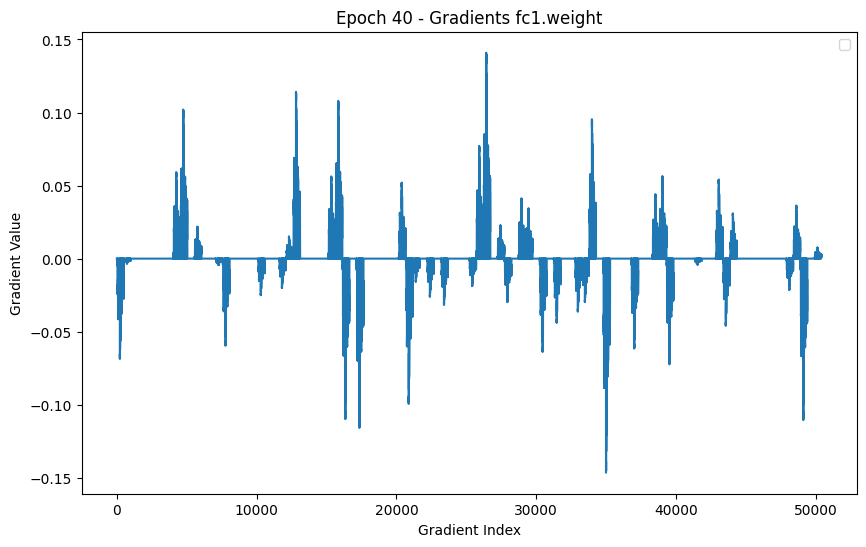

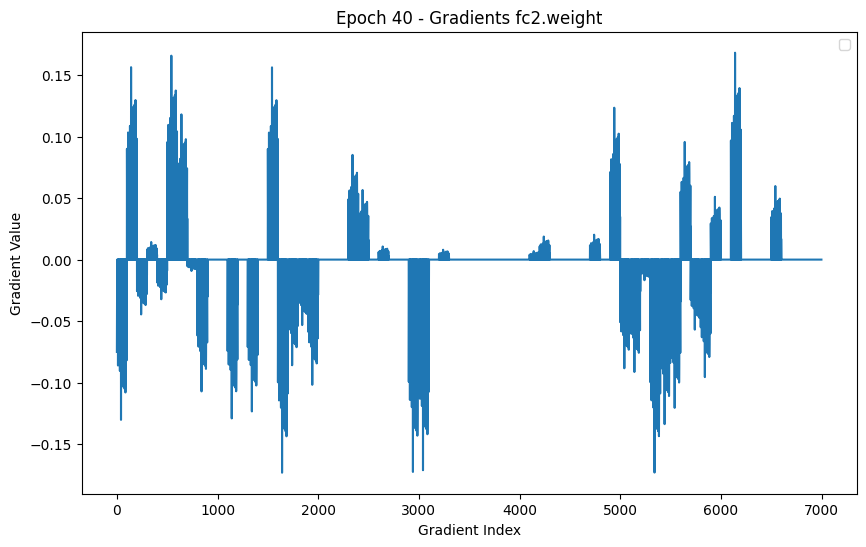

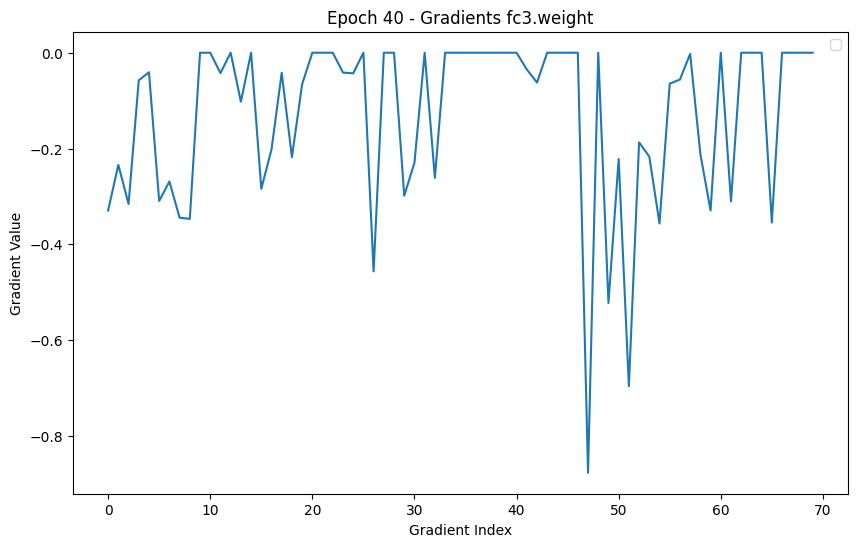

Loss is less than 0.000001:2.532694054480089e-10 Stopping training.
tensor(2.5327e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


In [294]:
loss = Train()
print(loss)

In [295]:
Save_Scenario_State_Model(scenario,net)
Save_Scenario_Full_Model(scenario,net)

In [296]:
# PATH = f'./model_scen_{0}_state.pth'
# Load_State_Model(net,PATH)
# PATH = f'./model_scen_{0}_full.pth'
# Load_Full_Model(PATH)

## Test CNN Results

Test Results

In [309]:
def calculate_iqr(tensor_list):
    stack = torch.stack(tensor_list, dim=1)
    for stack_tensor in stack:
        #print("stack_tensor shape",stack_tensor.shape)
        Q1 = np.percentile(stack_tensor, 25)
        Q3 = np.percentile(stack_tensor, 75)
        IQR = Q3 - Q1
    
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        data_iqr = [x for x in stack_tensor if lower_bound <= x <= upper_bound]
        #print("dataiqr",data_iqr)
        error_pct_outside_iqr = ((len(stack_tensor) - len(data_iqr)) / len(stack_tensor)) * 100
        #print("len dataiqr",len(data_iqr))
        #print("dropped",percentage_dropped)

    return data_iqr, error_pct_outside_iqr

def calculate_score(tensor_list):
    #print("tensor_list",tensor_list)
    stack = torch.stack(tensor_list, dim=1)
    print("len stack",len(stack.data[0]))
    print("true_sum",torch.sum(stack,dim=1))
    true_sum = torch.sum(stack,dim=1)
    score = (true_sum/len(stack.data[0]))*100
    print("score in",score)
    return score

def Test(test_loader=test_loader, net=net):
    predicted = []
    actual = []
    accuracy = 0
    correct_2dp_list = []
    correct_1dp_list = []
    error_list = []
    #dataframe vars
    predicted_list = []
    actual_list = []
    abs_percentage_diffs_list = []

    for i, data in enumerate(test_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        
        predicted.append(outputs)
        actual.append(labels)
        
        predicted_tensor = outputs.data
        actual_tensor = labels.data
        
        predicted_tensor_cpu = predicted_tensor.cpu().detach()
        predicted_list.append(predicted_tensor_cpu)

        actual_tensor_cpu = actual_tensor.cpu().detach()
        actual_list.append(actual_tensor_cpu)
        
        #calculate batch pct difference
        batch_abs_percentage_diff = (torch.abs(predicted_tensor - actual_tensor) / torch.abs(actual_tensor)) * 100
        abs_percentage_diffs_list.extend(batch_abs_percentage_diff.cpu().detach().numpy().flatten())

        #Check IQR
        error_tensor = (predicted_tensor - actual_tensor).cpu().detach()
        error_list.append(error_tensor)
        
        #accuracy to x d.p
        correct_2dp_tensor = (torch.abs(predicted_tensor - actual_tensor)<= 0.01).cpu().detach()
        correct_2dp_list.append(correct_2dp_tensor)
        
        correct_1dp_tensor = (torch.abs(predicted_tensor - actual_tensor)<= 0.1).cpu().detach()
        correct_1dp_list.append(correct_1dp_tensor)

    correct_2dp_score = calculate_score(correct_2dp_list)
    correct_1dp_score = calculate_score(correct_1dp_list)
    
    error_list_iqr, error_pct_outside_iqr = calculate_iqr(error_list)

    print("error_pct_outside_iqr",error_pct_outside_iqr)

    #actual and predicted mean
    #print("actual list",actual_list)
    stack_actual = torch.stack(actual_list, dim=0)
    print("stack actual shape",stack_actual.shape,"stack actual",stack_actual)

    stack_predicted = torch.stack(predicted_list, dim=0)
    
    accuracy = [correct_2dp_score, correct_1dp_score]
    print(); print(f"Percentage of predictions within "
            f"2 decimal places: {correct_2dp_score}%, "
            f"1 decimal places: {correct_1dp_score}%,\n"
            f"average actual shape: {stack_actual.shape} values: {(torch.mean(stack_actual, dim=1))}, "
            f"average predicted shape: {stack_predicted.shape} values: {(torch.mean(stack_predicted, dim=1))}")

    #print("abs_percentage_diffs",abs_percentage_diffs_np)
    return predicted_list, actual_list, accuracy, stack_actual, stack_predicted 

In [310]:
predicted_list, actual_list, accuracy, stack_actual, stack_predicted  = Test(net=net)

len stack 64
true_sum tensor([[2]])
score in tensor([[3.1250]])
len stack 64
true_sum tensor([[21]])
score in tensor([[32.8125]])
error_pct_outside_iqr 4.6875
stack actual shape torch.Size([64, 1, 1]) stack actual tensor([[[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[ 0.7898]],

        [[-0.3127]],

        [[-0.3127]],

        [[-0.3127]],

        [[-0.312

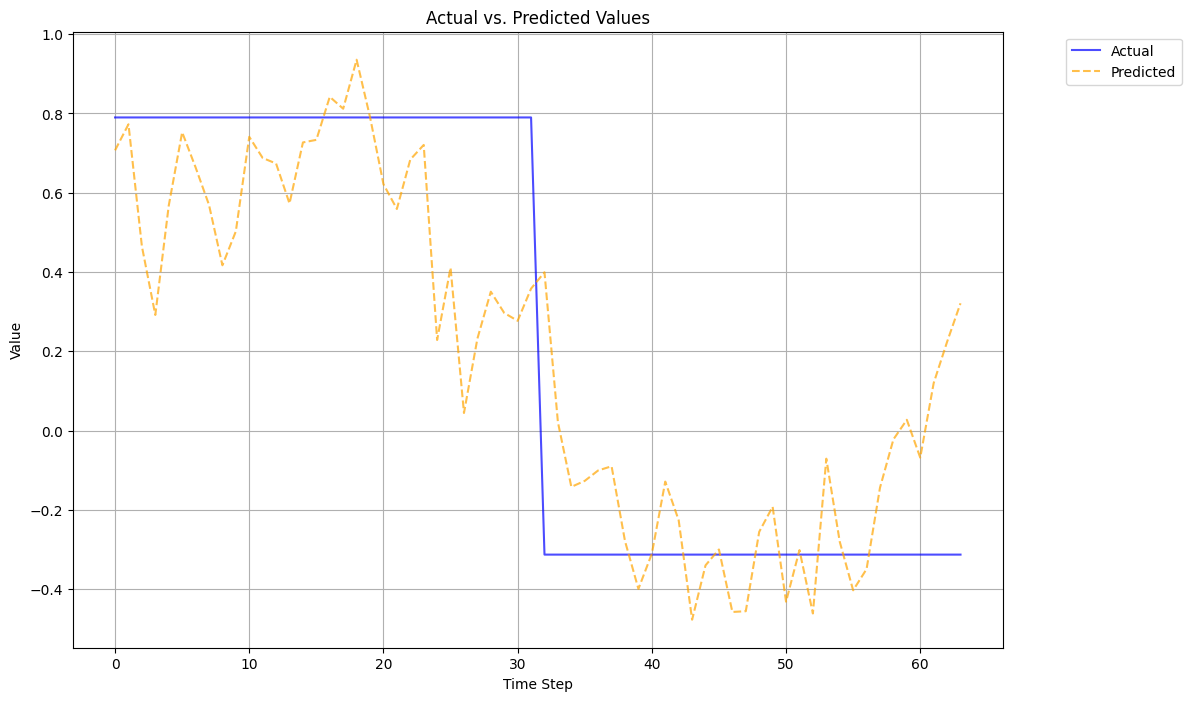

In [308]:
plt.figure(figsize=(12, 8))

mean_actual = torch.mean(stack_actual, dim=1).cpu().numpy().flatten()
mean_predicted = torch.mean(stack_predicted, dim=1).cpu().numpy().flatten()

plt.plot(mean_actual, linestyle='-', alpha=0.7, color='blue', label='Actual')
plt.plot(mean_predicted, linestyle='--', alpha=0.7, color='orange', label='Predicted')

# Add titles and labels
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))  # Adjust legend position
plt.grid(True)

# Show the plot
plt.show()

In [300]:
#write to file
output_string = (f"Accuracy 2dp: {accuracy[0]}%\n"
                 f"Accuracy 1dp: {accuracy[1]}%\n")

Scenario_Log(output_string)
print(output_string)

Accuracy 2dp: tensor([[3.1250]])%
Accuracy 1dp: tensor([[32.8125]])%



## Bayesian Optimization for CNN Hyperparameters

In [301]:
def CNN_Optimization(output_conv_1, 
                     output_conv_2,
                     dropout_probab,
                     learning_rate,
                     momentum,
                     train_loader,test_loader,
                     iteration=None):
    
    output_conv_1 = int(output_conv_1)
    output_conv_2 = int(output_conv_2)
    
    net = Net(output_conv_1=output_conv_1, output_conv_2=output_conv_2,dropout_probab=dropout_probab)
    net.to(device)

    Train(learning_rate=learning_rate, train_loader=train_loader, net=net, momentum=momentum)

    if iteration is not None:
        Save_BayesOpt_Model(iteration,net)

    predicted, actual, accuracy, percentage_diffs, mean_percentage_diff = Test(test_loader=test_loader,net=net)
    
    print("accuracy received",accuracy)

    return accuracy

In [302]:
from bayes_opt import BayesianOptimization
#from functools import partial

def Optimize():
    
    Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, train_shuffle=False, batch_size=batch_size)
    
    iteration_counter = [0]

    def cnn_correct_pct_wrapper(output_conv_1, output_conv_2, learning_rate, dropout_probab, momentum):
        result = CNN_Optimization(output_conv_1, output_conv_2, learning_rate, dropout_probab, momentum, train_loader, test_loader, iteration=iteration_counter[0])
        iteration_counter[0] += 1
        return result
    #cnn_correct_pct = partial(CNN_Optimization, train_loader = train_loader, test_loader = test_loader)

    # Bounded region of parameter space
    pbounds = {'output_conv_1': (40, 80),
               'output_conv_2': (8, 16), 
               'learning_rate': (0.00001, 0.0001), 
               'dropout_probab': (0.0, 0.5), 
               'momentum': (0.8, 1.0)}

    optimizer = BayesianOptimization(
        f = cnn_correct_pct_wrapper,
        pbounds=pbounds,
        random_state=1,
        )

    #n_iter:steps of bayesian optimization you want to perform
    #init_points:steps of random exploration
    optimizer.maximize(init_points=10, n_iter=10,)

    with open(f'optimizer_results.txt', 'a') as file:
        for i, res in enumerate(optimizer.res):
            print(f"Iteration {i}: \n\t{res}")
            file.write("\n\nIteration {}: \n\t{}".format(i, res))

    optimizer_max_result = optimizer.max
    print("optimizer result:\n",optimizer.max)

    with open(f'optimizer_results.txt', 'a') as file:
        file.write('\noptimizer results:\n' + str(optimizer_max_result))

In [303]:
# comment out to not run bayesian opt
#Optimize()

In [304]:
# example to reconstruct Net model design. Enter optimizer_results.txt scenario variable results used to validate the net design model inference result matches the optimizer_results.txt output
# dropout_probab = 0.4473033317519236
# learning_rate = 1.7653979023280013e-05
# momentum = 0.8078109566465765
# output_conv_1 = int(46.7)
# output_conv_2 = int(15.0)

# net = Net(name='Classification Net', filter_size_1=filter_size_1, filter_size_2=filter_size_2,
#             filter_size_3=filter_size_3, stride=stride,
#             image_resolution_x=32,image_resolution_y=32,
#             output_conv_1=output_conv_1, output_conv_2=output_conv_2,
#             output_FC_1=output_FC_1, output_FC_2=output_FC_2,
#             final_FCLayer_outputs=final_FCLayer_output,
#             dropout_probab=dropout_probab)

# net.to(device)
# net.parameters()

# net = Load_BayesOpt_Model("5",net)

# predicted_np, actual_np, accuracy, percentage_diffs, mean_percentage_diff, average_percentage_diff, df = Test_And_Report(net)
